# Nooh bin Sikander

# Advanced Data Science with IBM Capstone: predicting outcome of a social benefit application
This is the Capstone project for Coursera "Advanced Data Science with IBM" Specialization. We trying to predict the result (approved / not approved) of housing benefit application. This is a real life use case from my current employer (with no personal information included).

## Problem description
I am currently working for Social Security Institution of Finland, a government agency whose main job is to provide social benefits for people residing in Finland. One of the benefits is housing benefit, which supports people with their living expenses in case of for example unemployment. 

Currently housing benefit applications arrive from our e-service channel as XML document and some appendices (pdf or jpeg files, such as rental agreement) or in paper. If application arrives in paper, it and its appendices are scanned. The difference to e-service channel from case handler's point of view is that application information is not available as structured data, meaning the that application information has to be manually input to the system before benefit handling and decision-making can take place.

It takes in the order of 10 minutes to process a housing benefit application (including the above mentioned manual input of data). While this does not sound like much, we receive in the order of 400 000 applications per year. If we could automate benefit decision making of even a subset of the applications, this would be useful for us and the taxpayers, too. Of these 400 000 applications, roughly 100 000 are "new" housing benefit applications, and 300 000 are "control" applications, meaning that the existing level of housing benefit is re-calculated based on changes in income, rent or other factors affecting the level of the benefit.

We will try to answer the following question:
* Can you predict the decision phrases of housing benefit applications, given application and relevant customer data (at least for some subset of applications)?


## Initial data exploration
Data of housing benefit applications and decisions is available in my company's data warehouse's staging area in a Netezza SQL database. The data is in some 40 database tables, much in the same format as in operative benefit system database - but with personal information masked. I will not be including personal information in the dataset at all, since they have no effect whatsoever on housing benefit decision contents.

I can export data from Netezza as CSV files, which I can then upload to IBM Cloud for processing.

A number of factors affect decisions of housing benefits:
* Number of children in the household - the more children, the more benefit
* Income of the members of household - income of all household members is taken into account. This can be for example
    * Salary
    * Other social benefits
    * Dividends from stocks
    * Interest from savings
    * ...or any other form of income

Of particular interest is that your wealth, in the form of apartments, houses, stocks or savings does not have any effect on housing benefit (rents from the apartments you own, dividends from stocks and interest from savings are considered income, though). This may sound counter-intuitive, but this is the way the legislation currently is.

The information stated above can be fetched from the Netezza with SQL. We need to make quite a few joins, since the data has been quite heavily normalized in the operative databases, and staging area reflects this structure directly.
`
SELECT VIRA.ASIAKAS_ID as ClientNumber, VIRA.RATJNO as DecisionNumber, PERU.PAAJNO as DecisionVersion, SUBSTR(PERU.PERUKO,3,3) AS PhraseCode,
			PERU.PEKASI AS ManuallyAdded,  PERU.PEMUUT AS ManuallyChanged, MUU.MUETLJ AS OtherBenefitType, MUU.MUETOSA AS OtherBenefitSubType,
			TULO.TULOLJ AS IncomeType, HLO.RKASIAKAS_ID AS HouseholdMembers
	FROM KADMIN.STG_AYVIRA AS VIRA 
		LEFT JOIN KADMIN.STG_AYRAT AS RAT ON VIRA.ASIAKAS_ID=RAT.ASIAKAS_ID AND VIRA.EJ=RAT.EJ AND VIRA.RATJNO=RAT.RATJNO AND VIRA.AJNO=RAT.AJNO
		LEFT JOIN KADMIN.STG_AYRMUET AS RMUU ON VIRA.ASIAKAS_ID=RMUU.ASIAKAS_ID AND VIRA.EJ=RMUU.EJ AND VIRA.RATJNO=RMUU.RATJNO
		LEFT JOIN KADMIN.STG_AYMUET AS MUU ON VIRA.ASIAKAS_ID=MUU.ASIAKAS_ID AND VIRA.EJ=MUU.EJ AND MUU.MUETJNO=RMUU.MUETJNO
		LEFT JOIN KADMIN.STG_AYRTULO AS RTULO ON VIRA.ASIAKAS_ID=RTULO.ASIAKAS_ID AND VIRA.EJ=RTULO.EJ AND VIRA.RATJNO=RTULO.RATJNO
		LEFT JOIN KADMIN.STG_AYTULO AS TULO ON VIRA.ASIAKAS_ID=TULO.ASIAKAS_ID AND VIRA.EJ=TULO.EJ AND TULO.TULOJNO=RTULO.TULOJNO
		LEFT JOIN KADMIN.STG_AYRRUOHE AS RHLO ON VIRA.ASIAKAS_ID=RHLO.ASIAKAS_ID AND VIRA.EJ=RHLO.EJ AND VIRA.RATJNO=RHLO.RATJNO
		LEFT JOIN KADMIN.STG_AYRUOHE AS HLO ON VIRA.ASIAKAS_ID=HLO.ASIAKAS_ID AND VIRA.EJ=HLO.EJ AND RHLO.RKJNO=HLO.RKJNO
		LEFT JOIN KADMIN.STG_RPPERU AS PERU ON RAT.ASIAKAS_ID=PERU.ASIAKAS_ID AND RAT.EJ=PERU.EJ AND RAT.RATJNO=PERU.RATJNO
		WHERE VIRA.VIRALJ='U' AND VIRA.EJ='AY' AND RAT.ELRATLA='MYÖ' AND VIRA.VIRAJNO=1 AND PERU.PAAJNO=1
		ORDER BY VIRA.ASIAKAS_ID ASC, VIRA.RATJNO ASC, PERU.PERUJNO ASC
		LIMIT 500;
`

The WHERE clauses above limit the result set to "new" housing benefit applications for which a decision has been made. The PhraseCodes will be used to form our category labels in a way described later. Note that the where clauses are not  exactly same, meaning we have to be careful when combining data sets.

Example outpt from statement:
`
CLIENTNUMBER	DECISIONNUMBER	DECISIONVERSION	PHRASECODE	MANUALLYADDED	MANUALLYCHANGED	OTHERBENEFITTYPE	OTHERBENEFITSUBTYPE	INCOMETYPE	HOUSEHOLDMEMBERS
333073408	16	1	B15	NULL	K	TP	NULL	01	333073408
333073408	16	1	B15	NULL	K	TP	NULL	01	333073408
333073408	16	1	B15	NULL	K	TP	NULL	01	333073408
333073408	16	1	B15	NULL	K	TP	NULL	01	333073408
333073408	16	1	B15	NULL	K	TP	NULL	01	726046341
333073408	16	1	B15	NULL	K	TP	NULL	01	333073408
`

We can use the columns CLIENTNUMBER and DECISIONNUMBER to combine these datasets later. We can further see many things from the above examples:
* There are a lot of NULL values
* We need to do a lot of categorization (DECISION, OTHERBENEFITTYPE, OTHERBENEFITSUBTYPE, INCOMTETYPE)


## Studying the dataset containing all housing benefit decision phrases
We will first load and study dataset containing decision phrases of all housing benefit decisions

In [3]:
# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
from ibm_botocore.client import Config
import ibm_boto3
import types
import pandas as pd
client_fb77205e2d164977b331a46f3ff3b2e9 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
def __iter__(self): return 0

In [2]:


body = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='AY_decision_phrases_all1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_phrases = pd.read_csv(body, sep='|', skiprows=[0], 
                         names=['ClientNumber','DecisionNumber','DecisionVersion','PhraseCode'], 
                         usecols=['ClientNumber','DecisionNumber','PhraseCode'], header=None)
df_phrases.head()

,ClientNumber,DecisionNumber,PhraseCode
0,332871451,1,C70
1,332871451,1,C60
2,332871451,1,C69
3,332871451,1,C72
4,332871451,1,C64


In [3]:
df_phrases.shape

(6191053, 3)

We need to group the dataframe so that decision phrases from a sincle decision get grouped together. We need to do this in such a way that the order of phrases is preserved. We can do this with Pandas groupby function, and applying join operation to the phrase list.

In [4]:
%time df_phrases_grouped = pd.DataFrame(df_phrases.groupby(['ClientNumber','DecisionNumber'], sort=False)['PhraseCode'].apply(','.join)).reset_index()
df_phrases_grouped.rename(index=str, columns={'PhraseCode':'PhraseCodes'}, inplace=True)
df_phrases_grouped.head()

CPU times: user 23.6 s, sys: 817 ms, total: 24.4 s
Wall time: 24.4 s


,ClientNumber,DecisionNumber,PhraseCodes
0,332871451,1,"C70,C60,C69,C72,C64,C65,C74,Y10,M02,Z01,S03,D1..."
1,332871457,2,"C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0..."
2,332871463,2,"C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0..."
3,332871559,11,"C02,C70,C60,C69,C72,C64,C65,C74,T01,Z02,S03,V0..."
4,332871574,1,"C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0..."


In [5]:
df_phrases_grouped.shape

(357405, 3)

For the business problem at hand, the list of phrase codes is actually a category for machine learning algorithms! In practise this means "a document with the the following phrases in the following order". Here we have 375k decisions. Let us see how many different "categories" there are, and how common the categories are.

In [6]:
len(df_phrases_grouped['PhraseCodes'].unique().tolist())

93207

This really does not look very good - 357405 decisions fall into 93207 different categories! We need to study this a little further. Let us see the frequency distribution of different categories. It is to expected that some categories are much more common than others.

In [7]:
# Check whether some combinations are more common than others (this would be expected)
df_phrasecomb_frequencies = pd.DataFrame(df_phrases_grouped['PhraseCodes'].value_counts()).reset_index()
df_phrasecomb_frequencies.rename(index=str, columns={'index':'PhraseCodes','PhraseCodes':'Frequency'}, inplace=True)
df_phrasecomb_frequencies.head(10)

,PhraseCodes,Frequency
0,"L01,B34,V01,S03,W35",46878
1,"L01,B34,V01,S03,S03,W35",8251
2,"C01,C70,C60,C69,C72,C64,C65,C74,T01,Z02,S03,V0...",5005
3,"L01,B34,V01,S03,S03,S03,W35",4902
4,"C70,C60,C69,C72,C64,C65,C74,Y10,M01,Z02,S03,V0...",4628
5,"B33,L01,S03,V01,W24,P01,W17,W25",4153
6,"B19,L01,S03,V01",3684
7,"C01,C70,C60,C69,C72,C64,C65,C74,Y11,T01,Z02,S0...",3384
8,"L01,B34,V01,S03,S03,S03,S03,W35",2775
9,"C01,C70,C60,C69,C72,C64,C65,C74,T01,Z02,S03,V0...",2543


In [8]:
df_phrasecomb_frequencies.shape

(93207, 2)

In [18]:
df_phrasecomb_frequencies['PhraseCodes'][0:20]

0                                   L01,B34,V01,S03,W35
1                               L01,B34,V01,S03,S03,W35
2     C01,C70,C60,C69,C72,C64,C65,C74,T01,Z02,S03,V0...
3                           L01,B34,V01,S03,S03,S03,W35
4     C70,C60,C69,C72,C64,C65,C74,Y10,M01,Z02,S03,V0...
5                       B33,L01,S03,V01,W24,P01,W17,W25
6                                       B19,L01,S03,V01
7     C01,C70,C60,C69,C72,C64,C65,C74,Y11,T01,Z02,S0...
8                       L01,B34,V01,S03,S03,S03,S03,W35
9     C01,C70,C60,C69,C72,C64,C65,C74,T01,Z02,S03,V0...
10                                  B15,Y10,H01,S03,V01
11    C70,C60,C69,C72,C64,C65,C74,M01,Z02,S03,V01,U0...
12                                      B15,H01,S03,V01
13    C01,C70,C60,C69,C72,C64,C65,C74,Y11,T01,Z02,S0...
14    C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0...
15                                      B33,L01,S03,V01
16    C01,C70,C60,C69,C72,C62,C63,C74,T01,Z02,S03,V0...
17    O01,C01,C70,C60,C69,C72,C64,C65,C74,T03,T0

When the contents of the phrases are studied (sorry, available only in Finnish and Swedish), it is noted that the most common combination is a letter saying that housing benefit has been canceled, because the customer has not sent the required appendices in due time (in which case housing benefit cannot be calculated). This is a letter that is already being produced automatically with a batch program.

Let us draw a bar chart of the the first let us say 100 items of the frequency distribution.

Text(0.5,1,'Decisions by content in data set')

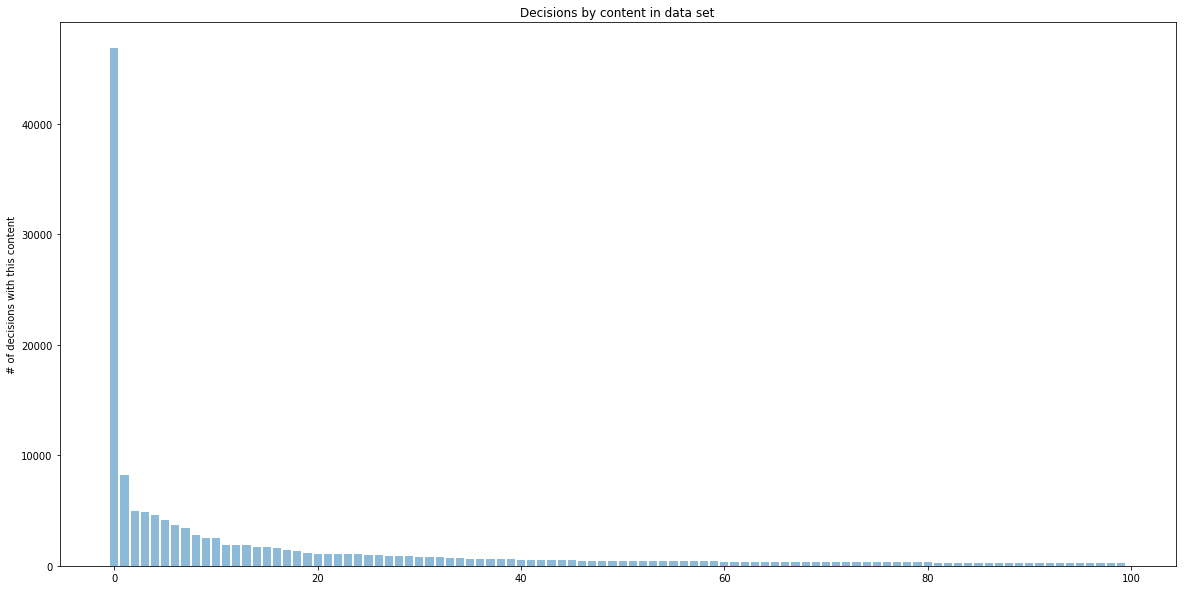

In [29]:
# Bar chart of first n_items categories
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

n_items = 100
y_pos = np.arange(n_items)
values = df_phrasecomb_frequencies['Frequency'][0:n_items]
plt.figure(figsize=(20,10))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.ylabel('# of decisions with this content')
plt.title('Decisions by content in data set')

As we can see, the list of frequencies has got a really long and shallow tail. Let us see, for example, the frequencies of decisions in 90-100th most common range 

In [25]:
df_phrasecomb_frequencies[90:100]

,PhraseCodes,Frequency
90,"O01,C01,C70,C60,C72,C64,C65,C74,T03,T07,Z02,S0...",285
91,"B33,L01,S01,S01,S01,S01,V01,W24,P01,W17,W25",284
92,"C02,C70,C60,C69,C72,C64,C65,C74,Y15,T01,Z02,S0...",283
93,"C70,C60,C69,C72,C64,C65,C74,M01,Z02,S03,V01,U0...",280
94,"C01,C70,C60,C69,C72,C64,C65,C74,Y11,T01,Z02,S0...",278
95,"B19,L01,S03,V01,P02",278
96,"C01,C70,C60,C69,C72,C64,C65,C74,Y11,T01,Z02,S0...",270
97,"C01,C70,C60,C69,C78,C81,C72,C64,C65,C74,T01,Z0...",267
98,"C70,C60,C69,C78,C76,C72,C64,C65,C74,Y10,M01,Z0...",264
99,"C02,C70,C60,C69,C72,C64,C65,C74,Y11,Y15,T01,Z0...",262


Let us see how many categories have 50 or more examples.

In [37]:
df_phrasecomb_frequencies[df_phrasecomb_frequencies['Frequency'] > 49].shape[0]

553

This may be too many categories.

## Interim result 1
It seems we are better off limiting the data set. The original data set consisted of all housing benefit decisions for the year 2018. Let us limit this dataset further by selecting only approved decisions of new applications. The original dataset contains all types of applications (most notably, control applications, too) and both approved and non-approved applications.

Businesswise this still makes sense, since we already have logic in place for deciding whether a application gets approved or not, and for each application we know the type of application in the very beginning of the application handling process.

In [100]:
body = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='AY_approved_first_decision_phrases.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_first_approve = pd.read_csv(body, sep='|', skiprows=[0], 
                         names=['ClientNumber','DecisionNumber','DecisionVersion','PhraseCode'], 
                         usecols=['ClientNumber','DecisionNumber','PhraseCode'], header=None)
df_first_approve.head()


,ClientNumber,DecisionNumber,PhraseCode
0,332871451,1,C70
1,332871451,1,C60
2,332871451,1,C69
3,332871451,1,C72
4,332871451,1,C64


In [101]:
df_first_approve_grouped = pd.DataFrame(df_first_approve.groupby(['ClientNumber','DecisionNumber'], sort=False)['PhraseCode'].apply(','.join)).reset_index()
df_first_approve_grouped.rename(index=str, columns={'PhraseCode':'PhraseCodes'}, inplace=True)
df_first_approve_grouped.head()

,ClientNumber,DecisionNumber,PhraseCodes
0,332871451,1,"C70,C60,C69,C72,C64,C65,C74,Y10,M02,Z01,S03,D1..."
1,332871574,1,"C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0..."
2,332871613,1,"C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0..."
3,332872984,1,"C70,C60,C69,C73,C72,C64,C65,C74,Y10,M01,Z02,S0..."
4,332873008,1,"C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0..."


In [102]:
df_first_approve_grouped['PhraseCodes'][0]

'C70,C60,C69,C72,C64,C65,C74,Y10,M02,Z01,S03,D11,V01,U03,U04,J02,Q25,Q04,Q01,Q02,Q02,Q06,Q07'

In [32]:
df_first_approve_grouped.shape

(59182, 3)

In [33]:
df_phrasecomb_frequencies2 = pd.DataFrame(df_first_approve_grouped['PhraseCodes'].value_counts()).reset_index()
df_phrasecomb_frequencies2.rename(index=str, columns={'index':'PhraseCodes','PhraseCodes':'Frequency'}, inplace=True)
df_phrasecomb_frequencies2.head()

,PhraseCodes,Frequency
0,"C70,C60,C69,C72,C64,C65,C74,Y10,M01,Z02,S03,V0...",4547
1,"C70,C60,C69,C72,C64,C65,C74,M01,Z02,S03,V01,U0...",1883
2,"C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0...",1674
3,"C70,C60,C69,C73,C72,C64,C65,C74,Y10,M01,Z02,S0...",921
4,"C70,C60,C69,C78,C72,C64,C65,C74,Y10,M01,Z02,S0...",857


In [34]:
df_phrasecomb_frequencies2.shape

(13875, 2)

In [36]:
df_phrasecomb_frequencies2[df_phrasecomb_frequencies2['Frequency'] > 49].shape[0]

129

# Interim result 2

This looks slightly better - 59182 decisions in 13875 categories, 129 of which contain more than 50 examples. We'll continue with this data set.

Now we need the features for the data to be used in the modeling. Based on the domain knowledge and studying the contents of the decisions, it seems that most of the variation in contents is based on 
* other benefits of the applicant (these affect the level of benefit and are listed in decisions)
* income types of the applicant (these affect the level of benefit, too)
* household members (these are listed in decision and again affect the level of benefit)

The end result is a CSV file much bigger (3,7 gigabytes) than the previous one - it is still produced by one SQL statement, meaning that there is quite much repeated information in the file. Luckily, we can read the CSV file and use "categorical" datatype, which is much better memorywise. We still have to read in chunks and do grouping on the fly in order to be able to process the file.

NOTE: this data set has been fetched at a later time and is thus bigger than the previous ones.

In [4]:
def __iter__(self): return 0
body = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='AY_approved_first_check_all_data2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
import os, pandas as pd

df_first_approve_all_grouped = pd.DataFrame() 

def f2(x):
     return pd.Series(dict(
                        OtherBenefitTypes = set(x['OtherBenefitType']), 
                        OtherBenefitSubTypes = set(x['OtherBenefitSubType']), 
                        IncomeTypes = set(x['IncomeType']),
                        ManuallyAdded = set(x['ManuallyAdded']),
                        ManuallyModified = set(x['ManuallyModified']),
                        HouseholdMembers = set(x['HouseholdMemberClientId']),
                        PhraseCodes = list(x['PhraseCode'])))

chunks = pd.read_csv(body, sep='|', skiprows=[0],
                         names=['ClientNumber','DecisionNumber','DecisionVersion','PhraseCode', 'ManuallyAdded', 'ManuallyModified', 'OtherBenefitType','OtherBenefitSubType', 'IncomeType','HouseholdMemberClientId'], 
                         usecols=['ClientNumber','DecisionNumber','PhraseCode','ManuallyAdded', 'ManuallyModified', 'OtherBenefitType', 'OtherBenefitSubType','IncomeType','HouseholdMemberClientId'],
                         dtype={'PhraseCode':'category','OtherBenefitType':'category', 'OtherBenefitSubType':'category','IncomeType':'category','HouseholdMemberClientId':'category','ManuallyAdded':'category', 'ManuallyModified':'category'},
                         header=None, encoding='utf-8', chunksize=50000)

for chunk in chunks:
    df_first_approve_all_grouped = df_first_approve_all_grouped.append(chunk.groupby(['ClientNumber','DecisionNumber'], sort=False).apply(f2))
df_first_approve_all_grouped = df_first_approve_all_grouped.reset_index()
df_first_approve_all_grouped.head()

,ClientNumber,DecisionNumber,HouseholdMembers,IncomeTypes,ManuallyAdded,ManuallyModified,OtherBenefitSubTypes,OtherBenefitTypes,PhraseCodes
0,332871451,1,{332871451},{nan},{nan},{nan},{OR},{OT},"[C70, C60, C69, C72, C64, C65, C74, Y10, M02, ..."
1,332871574,1,{332871574},{nan},"{nan, K}","{nan, K}",{nan},{TM},"[C70, C60, C69, C72, C64, C65, C74, Y10, Y15, ..."
2,332871613,1,"{332871613, 905825343}",{nan},{nan},{nan},"{HL, HH}",{WH},"[C70, C70, C70, C70, C60, C60, C60, C60, C69, ..."
3,332872984,1,{332872984},{30},"{nan, K}","{nan, E}",{nan},{nan},"[C70, C60, C69, C73, C72, C64, C65, C74, Y10, ..."
4,332873008,1,{332873008},{nan},{nan},{nan},{nan},{KR},"[C70, C60, C69, C72, C62, C63, C74, Y10, M01, ..."


Here we skip some boring data processing where we got rid of the sets ans lists, and calculated the number of household members, plus dropped columns ManuallyAdded and ManuallyModified.

In [103]:

body = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='df_first_approve_all_grouped3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_first_approve_all_grouped2 = pd.read_csv(body, sep=';', skiprows=[0], 
                         names=['ClientNumber','DecisionNumber','IncomeTypes','OtherBenefitTypes','OtherBenefitSubTypes','PhraseCodes','NumberOfHouseholdMembers'], 
                         header=None, low_memory=False, encoding='utf-8')
df_first_approve_all_grouped2 = df_first_approve_all_grouped2.fillna('')
df_first_approve_all_grouped2.reset_index(inplace=True)
df_first_approve_all_grouped2 = df_first_approve_all_grouped2.drop(columns={'index'})
df_first_approve_all_grouped2.head(10)


,ClientNumber,DecisionNumber,IncomeTypes,OtherBenefitTypes,OtherBenefitSubTypes,PhraseCodes,NumberOfHouseholdMembers
0,332871451,1,,OT,OR,"C70,C60,C69,C72,C64,C65,C74,Y10,M02,Z01,S03,D1...",1
1,332871574,1,,TM,,"C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0...",1
2,332871613,1,,WH,"HH,HL","C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0...",2
3,332872984,1,30,,,"C70,C60,C69,C73,C72,C64,C65,C74,Y10,M01,Z02,S0...",1
4,332873008,1,,KR,,"C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0...",1
5,332873440,1,,OT,OR,"C70,C60,C69,C72,C62,C63,C74,Y10,Y15,M01,Z02,S0...",1
6,332873473,1,,,,"C70,C60,C72,C62,C63,C74,Y10,M01,Z02,S03,V01,U0...",1
7,332873593,1,,OT,OR,"C70,C60,C69,C72,C64,C65,C74,Y15,M01,Z02,S03,V0...",1
8,332873602,1,,,,"C70,C60,C72,C62,C63,C74,Y10,M01,Z02,S03,V01,U0...",1
9,332873635,4,30,,,"C70,C60,C69,C73,C72,C62,C63,C74,Y10,M01,Z02,S0...",1


Next, let us study the frequencies

In [104]:
df_phrasecomb_frequencies5 = pd.DataFrame(df_first_approve_all_grouped2['PhraseCodes'].value_counts()).reset_index()
df_phrasecomb_frequencies5.rename(index=str, columns={'index':'PhraseCodes','PhraseCodes':'Frequency'}, inplace=True)
df_phrasecomb_frequencies5.head(10)

,PhraseCodes,Frequency
0,"C70,C60,C69,C72,C64,C65,C74,Y10,M01,Z02,S03,V0...",5710
1,"C70,C60,C69,C72,C64,C65,C74,M01,Z02,S03,V01,U0...",2411
2,"C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0...",2014
3,"C70,C60,C69,C72,C64,C65,C74,Y10,Y15,M01,Z02,S0...",1715
4,"C70,C60,C69,C78,C72,C64,C65,C74,Y10,M01,Z02,S0...",1044
5,"C70,C60,C69,C73,C72,C64,C65,C74,Y10,M01,Z02,S0...",1029
6,"C70,C60,C69,C72,C62,C63,C74,M01,Z02,S03,V01,U0...",932
7,"C70,C60,C69,C72,C62,C63,C74,Y10,M01,Z02,S03,V0...",931
8,"C70,C60,C69,C78,C76,C72,C64,C65,C74,Y10,M01,Z0...",821
9,"C70,C60,C69,C72,C64,C65,C74,Y15,M01,Z02,S03,V0...",746


In [6]:
df_first_approve_all_grouped2.shape

(65947, 7)

In [7]:
df_phrasecomb_frequencies5.shape

(12420, 2)

In [8]:
df_phrasecomb_frequencies5[df_phrasecomb_frequencies5['Frequency'] > 49].shape[0]

146

Let us see the bar chart of frequency distribution.

Text(0.5,1,'Decisions by content in data set')

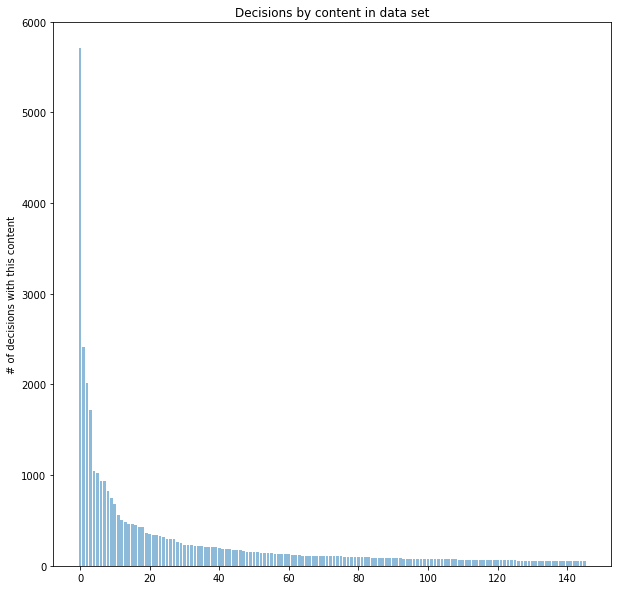

In [105]:
# Bar chart of first n_items categories
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

n_items = 146
y_pos = np.arange(n_items)
values = df_phrasecomb_frequencies5['Frequency'][0:n_items]
plt.figure(figsize=(10,10))
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.ylabel('# of decisions with this content')
plt.title('Decisions by content in data set')

In [10]:
# Number of cases with "common phrase combination", that is, more than 50 cases
df_phrasecomb_frequencies5[df_phrasecomb_frequencies5['Frequency'] >= 50]['Frequency'].sum()

37215

Let us now define the label for our modeling work. The index of the phrase combination in the list of most common phrase combinations will be used as the label. We will label the case with the index if the the phrases are the same as in the more common categories, meaning with 50+ examples in the data, and N_CATEGORIES otherwise.

In [11]:
# This function gives a value of -1, if not in N_CATEGORIES most common phrase code combinations
# If the list of phraseCodes equals one of the N_CATEGORIES most common phrase code combinations, 
# the index of that combination is list of most common phrase code combinations is returned
N_CATEGORIES = df_phrasecomb_frequencies5[df_phrasecomb_frequencies5['Frequency'] >= 50].shape[0] +1;
def findCategoryLabel(maxCategories, phraseCodes):
    categoryLabel = N_CATEGORIES;
    for i in range(maxCategories):
            if(phraseCodes == df_phrasecomb_frequencies5['PhraseCodes'][i]):
                return i
    return categoryLabel;
df_label = pd.DataFrame()
df_label['CategoryLabel'] = df_first_approve_all_grouped2.apply(lambda row: findCategoryLabel(N_CATEGORIES, row['PhraseCodes']), axis=1)
df_label.head(10)

,CategoryLabel
0,147
1,147
2,147
3,107
4,2
5,147
6,39
7,9
8,147
9,45


In [12]:
df_label.shape

(65947, 1)

In [13]:
df_data = df_first_approve_all_grouped2.copy();
df_data.drop(columns={'PhraseCodes','ClientNumber','DecisionNumber'}, inplace=True)
df_data.head(10)

,IncomeTypes,OtherBenefitTypes,OtherBenefitSubTypes,NumberOfHouseholdMembers
0,,OT,OR,1
1,,TM,,1
2,,WH,"HH,HL",2
3,30,,,1
4,,KR,,1
5,,OT,OR,1
6,,,,1
7,,OT,OR,1
8,,,,1
9,30,,,1


In [14]:
df_data.shape

(65947, 4)

Now we have our data and labels ready - at least for the first iteration - and can begin the actual modeling work

# Interim result 3
We now have a dataset which we think we might be able to categorize. In contains 65947 housing benefit decisions, falling into 12420 categories. We will try to create a machine learning model to identify whether the application received belongs to one of the 146 more popular decision types - that is, with more than 50 examples in our data set.

Businesswise, this set contains 37215/65947 = some 56% of "new" housing benefit applications. This a viable goal - remember, processing a single application takes around 10 minutes. 

## Some further preparation for the data set
One-hot encoding would produce a lot of features (1317, to be exact) I will do a little bit different encoding, which nevertheless will contain all needed information. The data in categories "IncomeTypes", "OtherBenefitTypes", "OtherBenefitSubTypes" can be a list of codes such as "OR,PO" or "HH,HL" or "HL,WL". If we do plain one-hot encoding for these characters, we would end up with columns like "otherBenefitTypes_OR,PO", "otherBenefitTypes_HH,HL" and "otherBenefitTypes_HL,WL" and so on. I want to do a coding which would produce columns like "otherBenefitType_OR", "otherBenefitType_PO","otherBenefitType_HH", "otherBenefitType_HL", "otherBenefitType_WL" and so on. So, each code will be categorized only once, not the ordered combination of the codes. Order other benefits (for example) is not important for this modeling task, but information about otherbenefit (whether it is received or not) is important.

First, we'll need to codes from the full data set, which we have stored in separate data sets.

In [76]:
# Read in the income type / benefit type / benefit subtype values to DataFrames and lists (we need these for one-hot encoding)
body1 = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='new_applications_benefitTypes.csv')['Body']
if not hasattr(body1, "__iter__"): body1.__iter__ = types.MethodType( __iter__, body1 )
df_otherBenefitTypes = pd.read_csv(body1, names=['OtherBenefitType'], skiprows=[0], header=None, encoding='utf-8')
otherBenefitTypeValues = df_otherBenefitTypes['OtherBenefitType'].unique()

body2 = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='new_application_benefitSubTypes.csv')['Body']
if not hasattr(body2, "__iter__"): body2.__iter__ = types.MethodType( __iter__, body2 )
df_otherBenefitSubTypes = pd.read_csv(body2, names=['OtherBenefitSubType'], skiprows=[0], header=None, encoding='utf-8')
otherBenefitSubTypeValues = df_otherBenefitSubTypes['OtherBenefitSubType'].unique()

body3 = client_fb77205e2d164977b331a46f3ff3b2e9.get_object(Bucket='advanceddatascience-donotdelete-pr-ffioxbyq1okbiu',Key='new_application_incomeTypes.csv')['Body']
if not hasattr(body3, "__iter__"): body3.__iter__ = types.MethodType( __iter__, body3 )
df_incomeTypes = pd.read_csv(body3, names=['IncomeType'], dtype={'IncomeType':'object'}, skiprows=[0], header=None, encoding='utf-8')
incomeTypeValues = df_incomeTypes['IncomeType'].unique()

In [77]:
df_data2 = pd.DataFrame()
def containsX(value, valueX):
    contains = 0
    if valueX in value:
        contains = 1
    return contains
for incomeType in incomeTypeValues:
    df_data2['incomeType_'+incomeType] = df_data['IncomeTypes'].apply(lambda x:containsX(x, incomeType))
for otherBenefitSubType in otherBenefitSubTypeValues:
    df_data2['otherSubBenefit_'+otherBenefitSubType] = df_data['OtherBenefitSubTypes'].apply(lambda x:containsX(x, otherBenefitSubType))
for otherBenefitType in otherBenefitTypeValues:
    df_data2['otherBenefit_'+otherBenefitType] = df_data['OtherBenefitTypes'].apply(lambda x:containsX(x, otherBenefitType))
df_data2.head(10)

,incomeType_30,incomeType_01,incomeType_05,incomeType_02,incomeType_04,incomeType_03,incomeType_23,otherSubBenefit_PM,otherSubBenefit_PO,otherSubBenefit_AL,...,otherBenefit_TR,otherBenefit_KU/O,otherBenefit_KU/T,otherBenefit_TT,otherBenefit_KURO,otherBenefit_YV/T,otherBenefit_TK-K,otherBenefit_DER,otherBenefit_LUKO,otherBenefit_KURE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we will add "normally one-hot encoded" number of household members in this data set.

In [78]:
df_data2 = pd.concat([df_data2, pd.get_dummies(df_data['NumberOfHouseholdMembers'], prefix='householdMembers_')], axis=1)
df_data2.head(10)

,incomeType_30,incomeType_01,incomeType_05,incomeType_02,incomeType_04,incomeType_03,incomeType_23,otherSubBenefit_PM,otherSubBenefit_PO,otherSubBenefit_AL,...,householdMembers__8,householdMembers__9,householdMembers__10,householdMembers__11,householdMembers__12,householdMembers__13,householdMembers__14,householdMembers__15,householdMembers__16,householdMembers__18
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling
We are required to create at least one deep learning model and at least one non-deep learning model for the problem. We will start with non-deep learning.
## Model 1: SVM
We will be trying out Support Vector Machine. SVM is relatively fast to train, and can be configured to support multiclass classification. We will be using F1 score for measure of success. In this case, every mislabeling is just as problematic, and F1 score balances these.

In [79]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.base import BaseEstimator

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df_data2, df_label, random_state=0)

In [82]:
# Start with trying out one model without a pipeline
model = LinearSVC(C=1.0, tol=1e-6, verbose=True, multi_class='ovr')

In [83]:
model.fit(X_train, np.ravel(y_train))

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-06,
     verbose=True)

In [84]:
%time yfit = model.predict(X_test)
print(classification_report(y_test, yfit))

CPU times: user 798 ms, sys: 293 ms, total: 1.09 s
Wall time: 110 ms
             precision    recall  f1-score   support

          0       0.22      0.75      0.34      1402
          1       0.00      0.00      0.00       631
          2       0.00      0.00      0.00       468
          3       0.00      0.00      0.00       419
          4       0.00      0.00      0.00       260
          5       0.00      0.00      0.00       252
          6       0.00      0.00      0.00       238
          7       0.00      0.00      0.00       223
          8       0.00      0.00      0.00       194
          9       0.00      0.00      0.00       186
         10       0.00      0.00      0.00       165
         11       0.00      0.00      0.00       133
         12       0.00      0.00      0.00       117
         13       0.00      0.00      0.00       130
         14       0.00      0.00      0.00        97
         15       0.00      0.00      0.00       109
         16       0.00      0

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# Duh... need to LabelEncode multiple columns
# We want to be able to create a Pipeline, thus cannot use pd.get_dummies which would do the job
# Seehttps://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
# We need to inherit this class from BaseEstimator, otherwise we cannot use this in GridSearchCV
class MultiColumnLabelEncoder(BaseEstimator):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [21]:
# Form a pipeline for modeling
labelencoder_features = MultiColumnLabelEncoder(columns={'IncomeTypes','OtherBenefitTypes','OtherBenefitSubTypes','NumberOfHouseholdMembers'})
onehotencoder_features = OneHotEncoder(categorical_features = [0,1,2,3], handle_unknown='ignore')
pipeline = Pipeline([('labels',labelencoder_features),
                     ('onehot',onehotencoder_features), 
                     ('model', LinearSVC(C=1.0, tol=1e-6, verbose=True, multi_class='ovr'))])

In [85]:
# This pipeline is here just in case we need to plug in encoding stuff
pipeline = Pipeline([('model', LinearSVC(C=1.0, tol=1e-6, verbose=True, multi_class='ovr'))])

In [86]:
%time pipeline.fit(X_train, np.ravel(y_train))

[LibLinear]CPU times: user 1min 5s, sys: 169 ms, total: 1min 5s
Wall time: 1min 5s


Pipeline(memory=None,
     steps=[('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-06,
     verbose=True))])

In [87]:
%time yfit = pipeline.predict(X_test)
print(classification_report(y_test, yfit))

CPU times: user 511 ms, sys: 196 ms, total: 707 ms
Wall time: 80.3 ms
             precision    recall  f1-score   support

          0       0.22      0.75      0.34      1402
          1       0.00      0.00      0.00       631
          2       0.00      0.00      0.00       468
          3       0.00      0.00      0.00       419
          4       0.00      0.00      0.00       260
          5       0.00      0.00      0.00       252
          6       0.00      0.00      0.00       238
          7       0.00      0.00      0.00       223
          8       0.00      0.00      0.00       194
          9       0.00      0.00      0.00       186
         10       0.00      0.00      0.00       165
         11       0.00      0.00      0.00       133
         12       0.00      0.00      0.00       117
         13       0.00      0.00      0.00       130
         14       0.00      0.00      0.00        97
         15       0.00      0.00      0.00       109
         16       0.00      

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


That does not look too good... Let us try some hyperparameter tuning to see whether the resuls can be improved.

In [88]:
param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__tol': [1e-9, 1e-8, 1e-7],
}
search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted')
search.fit(X_test, np.ravel(y_test))

[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibLinear]

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1e-06,
     verbose=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': [0.1, 1.0, 10.0], 'model__tol': [1e-09, 1e-08, 1e-07]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [89]:
%time yfit = search.best_estimator_.predict(X_test)
print(classification_report(y_test, yfit))

CPU times: user 760 ms, sys: 35.5 ms, total: 795 ms
Wall time: 122 ms
             precision    recall  f1-score   support

          0       0.31      0.21      0.25      1402
          1       1.00      0.00      0.00       631
          2       0.00      0.00      0.00       468
          3       0.00      0.00      0.00       419
          4       1.00      0.00      0.01       260
          5       0.00      0.00      0.00       252
          6       0.00      0.00      0.00       238
          7       0.00      0.00      0.00       223
          8       0.00      0.00      0.00       194
          9       0.00      0.00      0.00       186
         10       0.00      0.00      0.00       165
         11       0.00      0.00      0.00       133
         12       0.00      0.00      0.00       117
         13       0.00      0.00      0.00       130
         14       0.00      0.00      0.00        97
         15       0.00      0.00      0.00       109
         16       0.00      

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
search.best_params_

{'model__C': 0.1, 'model__tol': 1e-09}

This really does not look good - even with hyperparameter tuning, we are not getting F1 score to above 0.3. Let us try deep learning instead.

## Model 2: Simple neural network
Let us start with a simple neural network, which we will build with Keras and TensorFlow. 

Neural networks take in one-hot encoded stuff (not text). We will thus be having 1317 input neurons, and 147 output neurons. We will start with one hidden layer, and use 600 neurons in the hidden layer with 730 neurons (a good first guess for one layer is (input+output)/2). We will have drop layers before and after the hidden layer.

We'll measure success with accuracy.

In [91]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout

# Neural network expects a one-hot encoded 
df_label_onehot2 = pd.get_dummies(df_label, columns={'CategoryLabel'})
input_size = df_data2.shape[1]
output_size = df_label_onehot2.shape[1]
dropRate = 0.2

model = Sequential()
model.add(Dense(input_size, input_dim=input_size, kernel_initializer='normal', activation='relu'))
model.add(Dropout(dropRate))
model.add(Dense(((input_size+output_size)//2), kernel_initializer='normal', activation='relu'))
model.add(Dropout(dropRate))
model.add(Dense(output_size, kernel_initializer='normal', activation='sigmoid'))

In [94]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
# Need to make a new split since output is one-hot encoded
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_data2, df_label_onehot2, random_state=0)

In [98]:
# Train model, start with 30 epochs
model.fit(X_train2, y_train2, epochs=30, batch_size=64)

Epoch 1/30
49460/49460 [==============================] - 3s 62us/step - loss: 0.0489 - acc: 0.9909
Epoch 2/30
49460/49460 [==============================] - 3s 54us/step - loss: 0.0219 - acc: 0.9941
Epoch 3/30
49460/49460 [==============================] - 3s 53us/step - loss: 0.0210 - acc: 0.9941
Epoch 4/30
49460/49460 [==============================] - 3s 54us/step - loss: 0.0206 - acc: 0.9941
Epoch 5/30
49460/49460 [==============================] - 3s 54us/step - loss: 0.0204 - acc: 0.9941
Epoch 6/30
49460/49460 [==============================] - 3s 54us/step - loss: 0.0202 - acc: 0.9941
Epoch 7/30
49460/49460 [==============================] - 3s 54us/step - loss: 0.0202 - acc: 0.9941
Epoch 8/30
49460/49460 [==============================] - 3s 52us/step - loss: 0.0201 - acc: 0.9941
Epoch 9/30
49460/49460 [==============================] - 3s 53us/step - loss: 0.0200 - acc: 0.9941
Epoch 10/30
49460/49460 [==============================] - 3s 53us/step - loss: 0.0200 - acc: 0.9941

In [99]:
model.evaluate(X_test2, y_test2)

16487/16487 [==============================] - 1s 39us/step


[0.019802677436357972, 0.99423007689750365]

Wow! Now we are talking. Even this simple neural network beats SVM hands down in this case. The result is impressive 99.4% accuracy. From business perspective, this would be enough. It is noteworthy that training this network was relatively fast, in the order of one minute in the environment used.

# Results and discussion
Our research question was this:
* Can you predict the decision phrases of housing benefit applications, given application and relevant customer data (at least for some subset of applications)?

We can now answer this question as follows: yes, we can reliably predict contents of housing benefit decisions based on quite limited number of input variables, if we limit ourselves to subsets of applications. The reliability is quite high, in the order of 99,4%.